# Cost of living & Venues Data Analysis of most popular cities in Bolivia

## 1. Introduction

### 1.1. Description & Disscusion of the Background

[Bolivia](https://en.wikipedia.org/wiki/Bolivia) according to the census conducted in 2012 has a population of 10,027,254 people, and the main cities according to the [population census](http://ibce.org.bo/publicaciones-descarga.php?id=2119&opcion=5) are:

| City |  Population   | Population Density |
|------|---------------|--------------------|
|  La Paz |  2.706.351 |      20.20         |
|  Santa Cruz |  2.706.351 |      7.16      |
|  Cochabamba |  2.706.351 |      31.60     |
|  Total      |  6.191.533 |          |

Only these 3 cities represent 61.74% of the general population, that is why the analysis will focus on these 3 cities in the following points:
*   Cost of living
*   Similarities between these 3 cities from the economic point of view
*   Relationship between the venues of each city through the Foursquare API to find similarities between the different districts of the city of La Paz, Santa Cruz and Cochabamba

This analysis allows people who have an interest in Bolivia to see a comparative analysis of the cost of living in relation to different cities, growth and if they decide to move what type of zones or districts can be ideal or similar between the larger cities from the country

### 1.2 Data Description

* For the cost of living analysis, [Numbeo](https://www.numbeo.com/cost-of-living/region_rankings.jsp?title=2010&region=005) data will be taken to determine the growth of the city of La Paz and a prediction model until the year 2025.

    For example data obtained for 2009:
	
|  City      |   Cost of Living Index      |Rent Index |Cost of Living Plus Rent Index|Groceries Index|Restaurant Price Index|Local Purchasing Power Index|
|-----------------------|---------------|------|-----|-----|-----|-----|
|  La Paz, Bolivia      |    46.72      |21.76 |36.82|27.09|37.16|32.47|
 	 	 	 	 	 	 	

* For the analysis of the 3 cities, the detailed data of the [Numbeo website](https://www.numbeo.com/cost-of-living/in/Santa-Cruz-Bolivia) will be obtained, including the cost of basic basket items, among others, and the comparison will be established against the different capitals of South America and the data clustering will be carried out to determine a classification and similarity between the different cities.

    A sample Data for Santa Cruz City

|Description|Price|
|-----------------------|---------------|
|Meal, Inexpensive Restaurant| 	3.18  |
|Meal for 2 People| 21.18 |
|Tomato (1kg)| 	1.04 |
|Potato (1kg)| 	0.67 |

* Finally, an analysis will be made between the different districts of the city of La Paz, Cochabamba and Santa Cruz to determine which districts are similar in relation to points of interest found through the [Foursquare API](https://developer.foursquare.com/).

    A sample data from Foursquare
|District|City|Venue| Venue Category| Latitude | Longitude|
|--------|-----------------------|---------------|-----|-----|----|
|District 1|Santa Cruz | Casa del Camba | Fast food | 23.123123| 22.2312|
|District 1|Cochabamba | Llajuuita | Fast food | 23.122323| 22.987621|
|Center |La Paz | Copacabana | Fast food | 23.122323| 22.987621|

## 2. Methodology

### 2.1 Obtaining and Formating Data

#### Installing Dependences

In [3]:
! easy_install beautifulsoup4

Searching for beautifulsoup4
Best match: beautifulsoup4 4.7.1
Adding beautifulsoup4 4.7.1 to easy-install.pth file

Using c:\users\edson\anaconda3\lib\site-packages
Processing dependencies for beautifulsoup4
Finished processing dependencies for beautifulsoup4


In [4]:
! easy_install html5lib

Searching for html5lib
Best match: html5lib 1.0.1
Adding html5lib 1.0.1 to easy-install.pth file

Using c:\users\edson\anaconda3\lib\site-packages
Processing dependencies for html5lib
Finished processing dependencies for html5lib


In [5]:
pip install geocoder

Note: you may need to restart the kernel to use updated packages.


In [6]:
!conda install -c conda-forge geopy --yes

Solving environment: ...working... done

# All requested packages already installed.



In [5]:
!conda install -c conda-forge folium=0.5.0 --yes

Solving environment: ...working... done

# All requested packages already installed.



#### Import Libraries

In [168]:
import pandas as pd
import requests
import numpy as np
import io
import requests
from bs4 import BeautifulSoup
import geocoder # import geocoder
from geopy.geocoders import Nominatim
import folium # map rendering library
# import k-means from clustering stage
from sklearn.cluster import KMeans
# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import math

Set and obtain the columns of the dataframe using a single request with random year

In [253]:
#Years for web scraping on Numbeo Page
years = ['2009','2010','2011','2012','2013','2014','2015','2016','2017','2018','2019']
#URL for web scrapping
urlCostLivingIndex = 'https://www.numbeo.com/cost-of-living/region_rankings.jsp?title={}&region=005'
urlCostLivingForHeaders = 'https://www.numbeo.com/cost-of-living/region_rankings.jsp?title=2009&region=005'
#create var for column data frame
columnNames = ['Year']
#create request only for obtain the value of headers using specific year
laPazCostLivingRequest = requests.get(urlCostLivingForHeaders)
laPazSoup = BeautifulSoup(laPazCostLivingRequest.text, "html5lib")

#Create the column Names for data frame
for tag in laPazSoup.find_all('table'):
        if (tag.get('id') == "t2"):
            for head in tag.thead.tr:
                name = head.string;
                if (name not in ['\n\t','\n\t\t']):
                    columnNames.append(name)
#Create a data frame with the table of Numbeo web page
dfLaPazCostLiving = pd.DataFrame(columns=columnNames)

Fill data for every single year

In [254]:
#Obtain data for every year using the array and one request for each year
for year in years:
    laPazCostLivingRequestPerYear = requests.get(urlCostLivingIndex.format(year))
    laPazSoupPerYear = BeautifulSoup(laPazCostLivingRequestPerYear.text, "html5lib")
    for tag in laPazSoupPerYear.find_all('table'):
        if (tag.get('id') == "t2"):
            rows = tag.find_all('tr')
            for row in rows:
                cols = row.find_all('td')
                cols = [ele.text.strip() for ele in cols]
                if (len(cols)!=0):
                    dfLaPazCostLiving = dfLaPazCostLiving.append({
                        'Year' : int(year),
                        'Rank' : cols[0],
                        'City': cols[1],
                        'Cost of Living Index' : float(cols[2]),
                        'Rent Index' : float(cols[3]),
                        'Cost of Living Plus Rent Index' : float(cols[4]),
                        'Groceries Index' : float(cols[5]),
                        'Restaurant Price Index' : float(cols[6]),
                        'Local Purchasing Power Index' : float(cols[7]),
                    }, ignore_index=True)

Clean and drop duplicate data and reset indexes, I considerer these values on the table as important for analysis.

In [260]:
laPazOnlyFiltered = dfLaPazCostLiving[dfLaPazCostLiving.City == 'La Paz, Bolivia']
#Delete duplicates and reorder data
laPazOnlyFiltered = laPazOnlyFiltered.drop_duplicates().reset_index(drop=True)
laPazOnlyFiltered.drop(labels=['Rank','Cost of Living Plus Rent Index','Local Purchasing Power Index','City'], axis=1,inplace = True)
laPazOnlyFiltered

,Year,Cost of Living Index,Rent Index,Groceries Index,Restaurant Price Index
0,2009,46.72,21.76,27.09,37.16
1,2010,39.76,19.41,26.40,37.85
2,2011,39.00,16.61,25.92,28.00
3,2014,38.71,11.85,38.58,22.88
4,2019,38.63,12.04,32.38,33.90


#### Show Plots for every variable through years

##### Year vs Cost of living

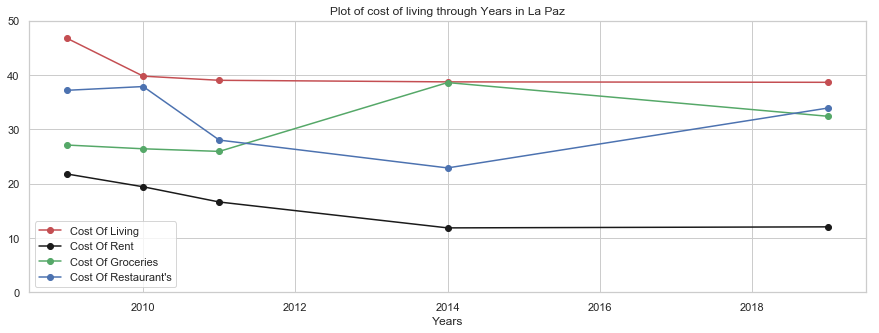

In [306]:
plt.figure(figsize=(15,5))
plt.plot('Year','Cost of Living Index','ro-', data = laPazOnlyFiltered , label = 'Cost Of Living')
plt.plot('Year','Rent Index', 'ko-', data = laPazOnlyFiltered, label = 'Cost Of Rent')
plt.plot('Year','Groceries Index', 'go-',data = laPazOnlyFiltered, label = 'Cost Of Groceries')
plt.plot('Year','Restaurant Price Index', 'bo-' ,data = laPazOnlyFiltered, label = "Cost Of Restaurant's")
plt.title('Plot of cost of living through Years in La Paz')
plt.xlabel('Years')
plt.ylim(0,50)
plt.legend()
plt.show()